# Hyperparameter Optimization

In [1]:
import os

from datetime import datetime
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import ray
from ray import tune
from ray import train
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler


from utils import get_hashes, convert_to_two_gram_scores, filter_two_grams, calculate_performance_metrics, run_epoch, label_tensors_to_two_grams

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import string
from early_stopping.early_stopping import EarlyStopping

from graphMatching.gma import run_gma

from datasets.bloom_filter_dataset import BloomFilterDataset
from datasets.tab_min_hash_dataset import TabMinHashDataset
from datasets.two_step_hash_dataset import TwoStepHashDataset

from pytorch_models_hyperparameter_optimization.base_model import BaseModel

Using NumPy dot (Mac)


In [2]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./data/datasets/fakename_1k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Eve",
    "Verbose": False,  # Print Status Messages
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False,
    "DevMode": False,
}


DEA_CONFIG = {
    "DevMode": False,
    "BatchSize": 32,
    # TestSize calculated accordingly
    "TrainSize": 0.8,
    "FilterThreshold": 0.5,
    "Patience": 10,
    "MinDelta": 1e-4,
    "NumSamples": 3,
    "Epochs": 30,
}

ENC_CONFIG = {
    # TwoStepHash / TabMinHash / BloomFilter
    "AliceAlgo": "TwoStepHash",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "None",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":1, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

In [3]:
# Get unique hash identifiers for the encoding and embedding configurations
eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash = get_hashes(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG)

# Define file paths based on the configuration hashes
path_reidentified = f"./data/available_to_eve/reidentified_individuals_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"
path_all = f"./data/dev/alice_data_complete_with_encoding_{eve_enc_hash}_{alice_enc_hash}_{eve_emb_hash}_{alice_emb_hash}.h5"

# Check if the output files already exist
if os.path.isfile(path_reidentified) and os.path.isfile(path_all):
    # Load previously saved attack results
    reidentified_data = hkl.load(path_reidentified)
    all_data = hkl.load(path_all)

else:
    # Run Graph Matching Attack if files are not found
    reidentified_data, _, all_data = run_gma(
        GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG, DEA_CONFIG,
        eve_enc_hash, alice_enc_hash, eve_emb_hash, alice_emb_hash
    )

# Convert lists to DataFrames
df_reidentified = pd.DataFrame(reidentified_data[1:], columns=reidentified_data[0])
df_all = pd.DataFrame(all_data[1:], columns=all_data[0])

In [4]:
# --- Generate a dictionary of all possible 2-grams from letters and digits ---

# Lowercase alphabet: 'a' to 'z'
alphabet = string.ascii_lowercase

# Digits: '0' to '9'
digits = string.digits

# Generate all letter-letter 2-grams (e.g., 'aa', 'ab', ..., 'zz')
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (e.g., '00', '01', ..., '99')
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (e.g., 'a0', 'a1', ..., 'z9')
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all generated 2-grams into one list
all_two_grams = letter_letter_grams + letter_digit_grams + digit_digit_grams

# Create a dictionary mapping index to each 2-gram
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

In [5]:
# 1️⃣ Bloom Filter Encoding
if ENC_CONFIG["AliceAlgo"] == "BloomFilter":
    data_labeled = BloomFilterDataset(
        df_reidentified,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    input_layer_size = len(df_reidentified["bloomfilter"][0])

# 2️⃣ Tabulation MinHash Encoding
elif ENC_CONFIG["AliceAlgo"] == "TabMinHash":
    data_labeled = TabMinHashDataset(
        df_reidentified,
        is_labeled=True,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )
    input_layer_size = len(df_reidentified["tabminhash"][0])

# 3 Two-Step Hash Encoding (One-Hot Encoding Mode)
elif ENC_CONFIG["AliceAlgo"] == "TwoStepHash":
    # Collect all unique integers across both reidentified and non-reidentified data
    unique_ints = sorted(set().union(*df_all["twostephash"]))
    unique_integers_dict = {i: val for i, val in enumerate(unique_ints)}
    input_layer_size = len(unique_ints)

    data_labeled = TwoStepHashDataset(
        df_reidentified,
        is_labeled=True,
        all_integers=unique_ints,
        all_two_grams=all_two_grams,
        dev_mode=GLOBAL_CONFIG["DevMode"]
    )

In [6]:
# Define dataset split proportions
train_size = int(DEA_CONFIG["TrainSize"] * len(data_labeled))
val_size = len(data_labeled) - train_size

# Split the reidentified dataset into training and validation sets
data_train, data_val = random_split(data_labeled, [train_size, val_size])

# Create DataLoaders for training, validation, and testing
dataloader_train = DataLoader(
    data_train,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=True  # Important for training
)

dataloader_val = DataLoader(
    data_val,
    batch_size=DEA_CONFIG["BatchSize"],
    shuffle=False  # Allows variation in validation batches
)

## Hyperparameter Tuning Setup for Training

This setup for hyperparameter tuning in a neural network model improves modularity, ensuring easy customization for experimentation.

1. **Model Initialization**:
   - The model is initialized using hyperparameters from the `config` dictionary, including the number of layers, hidden layer size, dropout rate, and activation function.

2. **Loss Function and Optimizer Selection**:
   - The loss function (`criterion`) and optimizer are selected dynamically from the `config` dictionary.

3. **Training & Validation Loop**:
   - The training and validation phases are handled in separate loops. The loss is computed at each step, and metrics are logged.

4. **Model Evaluation**:
   - After training, the model is evaluated on a test set, where 2-gram predictions are compared against the actual 2-grams.
   - **Dice similarity coefficient** is used as a metric to evaluate model performance.

5. **Custom Helper Functions**:
   - `extract_two_grams_batch()`: Extracts 2-grams for all samples in the batch.
   - `convert_to_two_gram_scores()`: Converts model output logits into 2-gram scores.
   - `filter_two_grams()`: Applies a threshold to filter 2-gram scores.
   - `filter_two_grams_per_uid()`: Filters and formats 2-gram predictions for each UID.

6. **Hyperparameter Tuning**:
   - The setup is integrated with **Ray Tune** (`tune.report`) to enable hyperparameter tuning by reporting the Dice similarity metric.


In [10]:
def train_model(config, dataloader_tr, dataloader_v, threshold):
    # Initialize lists to store training and validation losses
    train_losses = val_losses = []
    total_precision = total_recall = total_f1 = total_dice = 0.0
    n = len(dataloader_v.dataset)
    epochs = 0
    early_stopper = EarlyStopping(patience=DEA_CONFIG["Patience"], min_delta=DEA_CONFIG["MinDelta"])

    # Define and initialize model with hyperparameters from config
    model = BaseModel(
        input_dim=input_layer_size,
        output_dim=len(all_two_grams),
        num_layers=config["num_layers"],
        hidden_layer_size=config["hidden_layer_size"],
        dropout_rate=config["dropout_rate"],
        activation_fn=config["activation_fn"]
    )

    # Set device for model (GPU or CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Select loss function based on config
    loss_functions = {
        "BCEWithLogitsLoss": nn.BCEWithLogitsLoss(),
        "MultiLabelSoftMarginLoss": nn.MultiLabelSoftMarginLoss()
    }
    criterion = loss_functions[config["loss_fn"]]

    # Select optimizer based on config
    optimizers = {
        "Adam": optim.Adam(model.parameters(), lr=config["lr"]),
        "SGD": optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9),
        "RMSprop": optim.RMSprop(model.parameters(), lr=config["lr"])
    }
    optimizer = optimizers[config["optimizer"]]

    # Training loop
    for epoch in range(DEA_CONFIG["Epochs"]):
        epochs += 1
        # Training phase
        model.train()
        train_loss = run_epoch(model, dataloader_tr, criterion, optimizer, device, is_training=True, verbose=GLOBAL_CONFIG["Verbose"])
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = run_epoch(model, dataloader_v, criterion, optimizer, device, is_training=False, verbose=GLOBAL_CONFIG["Verbose"])
        val_losses.append(val_loss)

         # Early stopping check
        if early_stopper(val_loss):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Test phase with reconstruction and evaluation
    model.eval()

    with torch.no_grad():
        for data, labels, _ in dataloader_val:

            actual_two_grams = label_tensors_to_two_grams(two_gram_dict, labels)

            # Move data to device and make predictions
            data = data.to(device)
            logits = model(data)
            probabilities = torch.sigmoid(logits)

            # Convert probabilities into 2-gram scores
            batch_two_gram_scores = convert_to_two_gram_scores(two_gram_dict, probabilities)

            # Filter out low-scoring 2-grams
            batch_filtered_two_gram_scores = filter_two_grams(batch_two_gram_scores, threshold)

            # Calculate performance metrics for evaluation
            dice, precision, recall, f1 = calculate_performance_metrics(
                actual_two_grams, batch_filtered_two_gram_scores)

            total_dice += dice
            total_precision += precision
            total_recall += recall
            total_f1 += f1

    train.report({
            "average_dice": total_dice / n,
            "average_precision": total_precision / n,
            "average_recall": total_recall / n,
            "average_f1": total_f1 / n,
            "len_train": len(dataloader_tr.dataset),
            "len_val": len(dataloader_v.dataset),
            "epochs": epochs
        })

In [12]:
# Define search space for hyperparameter optimization
search_space = {
    "num_layers": tune.randint(1, 8),  # Vary the number of layers in the model
    "hidden_layer_size": tune.choice([128, 256, 512, 1024, 2048]),  # Different sizes for hidden layers
    "dropout_rate": tune.uniform(0.1, 0.4),  # Dropout rate between 0.1 and 0.4
    "activation_fn": tune.choice(["relu", "leaky_relu", "gelu"]),  # Activation functions to choose from
    "optimizer": tune.choice(["Adam", "SGD", "RMSprop"]),  # Optimizer options
    "loss_fn": tune.choice(["BCEWithLogitsLoss"]),  # Loss function (currently using BCEWithLogitsLoss)
    "lr": tune.loguniform(1e-5, 1e-2),  # Learning rate in a log-uniform range
}

# Initialize Ray for hyperparameter optimization
ray.init(ignore_reinit_error=True)

# Optuna Search Algorithm for optimizing the hyperparameters
optuna_search = OptunaSearch(metric="average_dice", mode="max")

# Use ASHAScheduler to manage trials and early stopping
scheduler = ASHAScheduler(metric="average_dice", mode="max")

trainable = tune.with_parameters(
    train_model,
    dataloader_tr = dataloader_train,
    dataloader_v = dataloader_val,
    threshold = DEA_CONFIG["FilterThreshold"]
)


# Define and configure the Tuner for Ray Tune
tuner = tune.Tuner(
    trainable,  # The function to optimize (training function)
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,  # Search strategy using Optuna
        scheduler=scheduler,  # Use ASHA to manage the trials
        num_samples=DEA_CONFIG["NumSamples"],  # Number of trials to run
        max_concurrent_trials=2  # or 1 if your models are heavy
    ),
    param_space=search_space  # Pass in the defined hyperparameter search space
)

# Run the tuner
results = tuner.fit()

# Shut down Ray after finishing the optimization
ray.shutdown()

2025-04-22 11:04:33,904	INFO tune.py:1042 -- Total run time: 25.62 seconds (25.49 seconds for the tuning loop).


✅ Results saved to all_trial_results.csv

🔍 Best_Result
----------------------------------------
Config: {'num_layers': 6, 'hidden_layer_size': 1024, 'dropout_rate': 0.32005363878974014, 'activation_fn': 'relu', 'optimizer': 'Adam', 'loss_fn': 'BCEWithLogitsLoss', 'lr': 0.0004570241984537996}
Average Dice: 0.0985
Average Precision: 0.9125
Average Recall: 0.0521
Average F1: 0.0985

🔍 Worst_Result
----------------------------------------
Config: {'num_layers': 3, 'hidden_layer_size': 512, 'dropout_rate': 0.282428738721588, 'activation_fn': 'leaky_relu', 'optimizer': 'SGD', 'loss_fn': 'BCEWithLogitsLoss', 'lr': 0.00043593878776595287}
Average Dice: 0.0348
Average Precision: 0.0180
Average Recall: 0.5152
Average F1: 0.0348

📊 Average Metrics Across All Trials
----------------------------------------
Average_dice: 0.0773
Average_precision: 0.6143
Average_recall: 0.2065
Average_f1: 0.0773
📊 Saved plot: metric_distributions.png
📌 Saved heatmap: correlation_heatmap.png


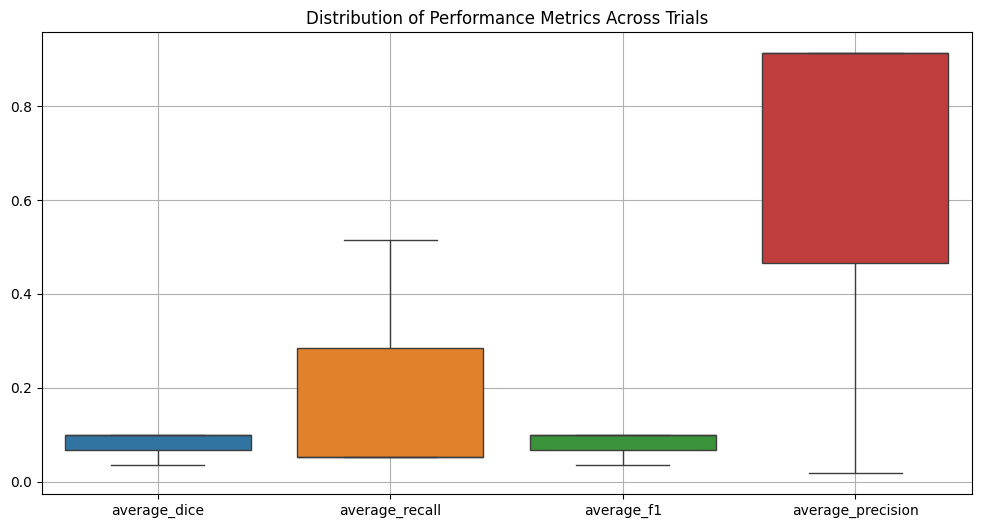

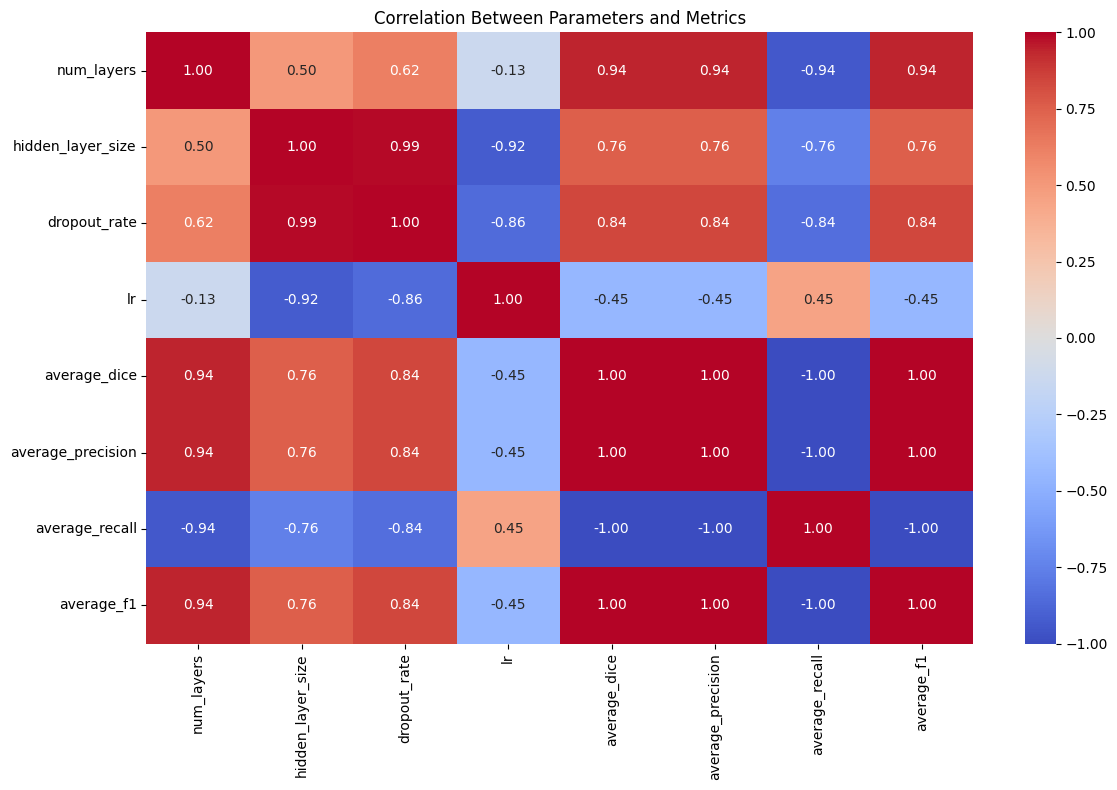

In [16]:
selected_dataset = GLOBAL_CONFIG["Data"].split("/")[-1].replace(".tsv", "")


experiment_tag = "experiment_" + ENC_CONFIG["AliceAlgo"] + "_" + selected_dataset + "_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_to = f"experiment_results/{experiment_tag}"
os.makedirs(save_to, exist_ok=True)
result_grid = results

# Best and worst result based on dice
best_result = result_grid.get_best_result(metric="average_dice", mode="max")
worst_result = result_grid.get_best_result(metric="average_dice", mode="min")

# Combine configs and metrics into a DataFrame
df = pd.DataFrame([
    {
        **result.config,
        **{k: result.metrics.get(k) for k in ["average_dice", "average_precision", "average_recall", "average_f1"]},
    }
    for result in result_grid
])

# Save to CSV
df.to_csv(f"{save_to}/all_trial_results.csv", index=False)
print("✅ Results saved to all_trial_results.csv")

def print_result(label, result):
    print(f"\n🔍 {label}")
    print("-" * 40)
    print(f"Config: {result.config}")
    print(f"Average Dice: {result.metrics.get('average_dice'):.4f}")
    print(f"Average Precision: {result.metrics.get('average_precision'):.4f}")
    print(f"Average Recall: {result.metrics.get('average_recall'):.4f}")
    print(f"Average F1: {result.metrics.get('average_f1'):.4f}")

    result_dict = {**result.config, **result.metrics}
    result_dict.pop("config", None)
    result_dict.pop("checkpoint_dir_name", None)
    result_dict.pop("experiment_tag", None)
    result_dict.pop("done", None)
    result_dict.pop("training_iteration", None)
    result_dict.pop("trial_id", None)
    result_dict.pop("date", None)
    result_dict.pop("time_this_iter_s", None)
    result_dict.pop("pid", None)
    result_dict.pop("time_total_s", None)
    result_dict.pop("hostname", None)
    result_dict.pop("node_ip", None)
    result_dict.pop("time_since_restore", None)
    result_dict.pop("iterations_since_restore", None)
    result_dict.pop("timestamp", None)
    # Convert to a DataFrame and save
    df = pd.DataFrame([result_dict])
    df.to_csv(f"{save_to}/{label}.csv", index=False)

print_result("Best_Result", best_result)
print_result("Worst_Result", worst_result)

# Compute and print average metrics
print("\n📊 Average Metrics Across All Trials")
avg_metrics = df[["average_dice", "average_precision", "average_recall", "average_f1"]].mean()
print("-" * 40)
for key, value in avg_metrics.items():
    print(f"{key.capitalize()}: {value:.4f}")

# --- 📈 Plotting performance metrics ---
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["average_dice", "average_recall", "average_f1", "average_precision"]])
plt.title("Distribution of Performance Metrics Across Trials")
plt.grid(True)
plt.savefig(f"{save_to}/metric_distributions.png")
print("📊 Saved plot: metric_distributions.png")

# --- 📌 Correlation between config params and performance ---
# Only include numeric config columns
numeric_config_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
correlation_df = df[numeric_config_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Parameters and Metrics")
plt.tight_layout()
plt.savefig(f"{save_to}/correlation_heatmap.png")
print("📌 Saved heatmap: correlation_heatmap.png")
